In [ ]:
# Импортируем библиотеки 
import tensorflow as tf
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import numpy as np
import os, sys, random, datetime
from tensorflow.keras.datasets import cifar10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Полносвязанная нейронная сеть**

In [ ]:
# Обозначем метки клааов
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

# Параметры обучения и оптимизации
learning_rate = 0.5
epochs = 20
batchSize = 100
img_size = (32, 32, 3)
# Оптимизатор и метрика
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
m = tf.keras.metrics.Accuracy()


In [ ]:
# Функция для загрузки датасета
def get_data(flatten = True):
  (X_train10, Y_train10), (X_test10, Y_test10) = cifar10.load_data()

  if (flatten):
    X_train10 = X_train10.reshape(-1, 3072)
    X_test10 = X_test10.reshape(-1, 3072)
  else:
    X_train10 = X_train10.reshape(-1, 32, 32, 3)
    X_test10 = X_test10.reshape(-1, 32, 32, 3)

  X_train10 = X_train10.astype(np.float32)/255
  X_test10 = X_test10.astype(np.float32)/255

  print(f'X_train10 = {X_train10.shape}')
  print(f'X_test10 = {X_test10.shape}')

  Y_train10 = utils.to_categorical(Y_train10, 10).astype(np.float32)
  Y_test10 = utils.to_categorical(Y_test10, 10).astype(np.float32)

  print(f'Y_train10 = {Y_train10.shape}')
  print(f'Y_test10 = {Y_test10.shape}')

  return X_train10, Y_train10, X_test10, Y_test10


In [ ]:
# Загрузили данные
X_train10, Y_train10, X_test10, Y_test10 = get_data()

170500096/170498071 [==============================] - 6s 0us/step
X_train10 = (50000, 3072)
X_test10 = (10000, 3072)
Y_train10 = (50000, 10)
Y_test10 = (10000, 10)


In [ ]:
# Тренируемые параметры
TrainParams = []

# Вес W1, 300 размер скрытого слоя
TrainParams.append(tf.Variable(tf.random.normal([3072, 30], stddev=0.03), name='W1'))

# Используя нормальное распределение со средни 0 и статистическим отклонением 0.03, определяем bias 
TrainParams.append(tf.Variable(tf.random.normal([30], stddev=0.03), name='b1'))

# Для весов и bias(откллонения) от скрытого к выходному
TrainParams.append(tf.Variable(tf.random.normal([30, 10], stddev=0.03), name='W2'))
TrainParams.append(tf.Variable(tf.random.normal([10], stddev=0.03), name='b2'))

# Функция подсчета ошибки
def loss(pred, target):
  return tf.losses.categorical_crossentropy(target, pred)

# Полносвязанный слой с несколькими функциями активации
def dense(x, params):
  W1 = params[0]
  b1 = params[1]
  W2 = params[2]
  b2 = params[3]

  hidden_out = tf.nn.relu( x @ W1 + b1)
  y = tf.nn.softmax(hidden_out @ W2 + b2)
  return y

# Модель
def model(x):
  y = dense(x, TrainParams)
  return y



In [ ]:
model(X_train10[[1]])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.11156564, 0.10157739, 0.10075769, 0.08467957, 0.09521645,
        0.07951672, 0.09832054, 0.11029885, 0.12002683, 0.09804034]],
      dtype=float32)>

In [ ]:
X_train10[1].shape

(3072,)

In [ ]:
Y_train10[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
# Функция вывода прогрессбара
def  print_log(current, amount, params):
  bar_len = 30
  percent = int(current * bar_len / amount)
  progressbar = ''

  for i in range(bar_len):
    if(i < percent):
      progressbar += '='
    elif(i == percent):
      progressbar += '>'
    else:
      progressbar += '-'

  message = '\r' + str(current) + '/' + str(amount) + '[' + progressbar + ']'
  for key in params:
    message += key + str(params[key]) + '.'

  sys.stdout.write(message)
  sys.stdout.flush()

# Функция тренировки сети
def train_model(train, inputs, outputs):
  with tf.GradientTape() as tape:
    current_loss = tf.reduce_mean(loss(model(inputs), outputs))
    grads = tape.gradient(current_loss, TrainParams)
    optimizer.apply_gradients(zip(grads, TrainParams))
    m.update_state(np.argmax(outputs, axis=1), np.argmax(model(inputs), axis=1))
  return current_loss, m.result().numpy()

In [ ]:
# Очищаем папку с записанной информацией обучения
!rm -R /content/drive/MyDrive/Tensorflow

rm: cannot remove '/content/drive/MyDrive/Tensorflow': No such file or directory


In [ ]:
PATH = '/content/drive/MyDrive/Tensorflow'

cur_time = datetime.datetime.now().strftime("%Y%m%d - %H%M%S")
loss_log_dir = PATH + cur_time +'/data' 
loss_summary_writer = tf.summary.create_file_writer(loss_log_dir)

amount_batches = int(len(X_train10)/ batchSize)

with loss_summary_writer.as_default():
  for epoch in range(1, epochs + 1):
    learning_epoch_start_time = datetime.datetime.now()
    print(f'\nЭпоха {epoch} / {epochs}')
    avg_loss = 0

    # Проходим по X_train10 с шагом batcSize
    for batch in range(0, len(X_train10), batchSize):
      current_loss, accuracy = train_model(model, X_train10[batch: batch + batchSize], Y_train10[batch: batch + batchSize])
      avg_loss += current_loss

    # Задаем параметры
    params = {'Время обучения: ': datetime.datetime.now() - learning_epoch_start_time, ' loss ': round(current_loss.numpy(), 4), ' accuracy ': round(accuracy, 4)}

    if(batch >= len(X_train10) - batchSize):
      params['loss: '] = round((avg_loss / amount_batches).numpy(), 4) 

    current_batch = int(batch / batchSize) + 1
    print_log(current_batch, amount_batches, params)

tf.summary.scalar('avg_loss', avg_loss, step=epoch)
tf.summary.scalar('accuracy', accuracy, step=epoch)
print()




Эпоха 1 / 20
500/500[==============================]Время обучения: 0:00:04.315695. loss 2.2993. accuracy 0.1218.loss: 2.3048.
Эпоха 2 / 20
500/500[==============================]Время обучения: 0:00:04.133748. loss 2.3053. accuracy 0.1211.loss: 2.302.
Эпоха 3 / 20
500/500[==============================]Время обучения: 0:00:04.095730. loss 2.2992. accuracy 0.1213.loss: 2.2997.
Эпоха 4 / 20
500/500[==============================]Время обучения: 0:00:04.043336. loss 2.2989. accuracy 0.1202.loss: 2.304.
Эпоха 5 / 20
500/500[==============================]Время обучения: 0:00:04.055295. loss 2.2991. accuracy 0.1196.loss: 2.3038.
Эпоха 6 / 20
500/500[==============================]Время обучения: 0:00:04.125044. loss 2.3161. accuracy 0.1194.loss: 2.3035.
Эпоха 7 / 20
500/500[==============================]Время обучения: 0:00:04.092852. loss 2.2992. accuracy 0.1197.loss: 2.3008.
Эпоха 8 / 20
500/500[==============================]Время обучения: 0:00:04.111288. loss 2.2995. accuracy 0.1198

Сеть разпознала: 


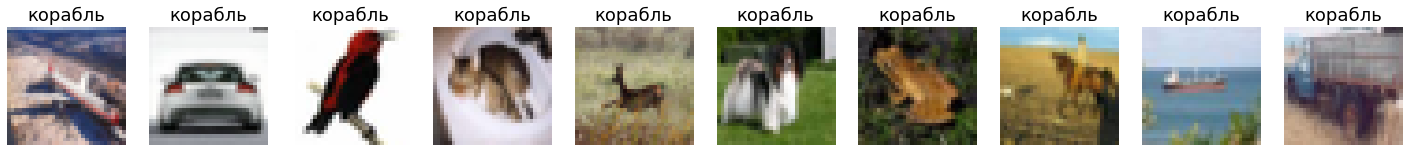

In [ ]:
# Выводим картинки по классам
print('Сеть разпознала: ')
fig, axs = plt.subplots(1, 10, figsize=(25, 3))
for i in range(10):
  label_ind = np.where(np.argmax(Y_test10, axis=1) == i)[0]
  ind = random.choice(label_ind)
  img = X_test10[ind]
  axs[i].imshow(img.reshape(img_size))
  axs[i].set_title(classes[np.argmax(model([img]))], size=18)
  axs[i].axis('off')
plt.show()
